[*********************100%***********************]  1 of 1 completed


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5091 - loss: 0.6979 - val_accuracy: 0.4878 - val_loss: 0.7136
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5474 - loss: 0.6855 - val_accuracy: 0.4989 - val_loss: 0.7086
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5240 - loss: 0.6894 - val_accuracy: 0.5011 - val_loss: 0.7100
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5558 - loss: 0.6866 - val_accuracy: 0.4900 - val_loss: 0.7092
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5496 - loss: 0.6841 - val_accuracy: 0.4945 - val_loss: 0.7097
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5650 - loss: 0.6843 - val_accuracy: 0.5011 - val_loss: 0.7131
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5547 - loss: 0.6856 - val_accuracy: 0.4989 - val_loss: 0.7102
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5491 - loss: 0.6833 - val_accuracy: 0.4989 - v

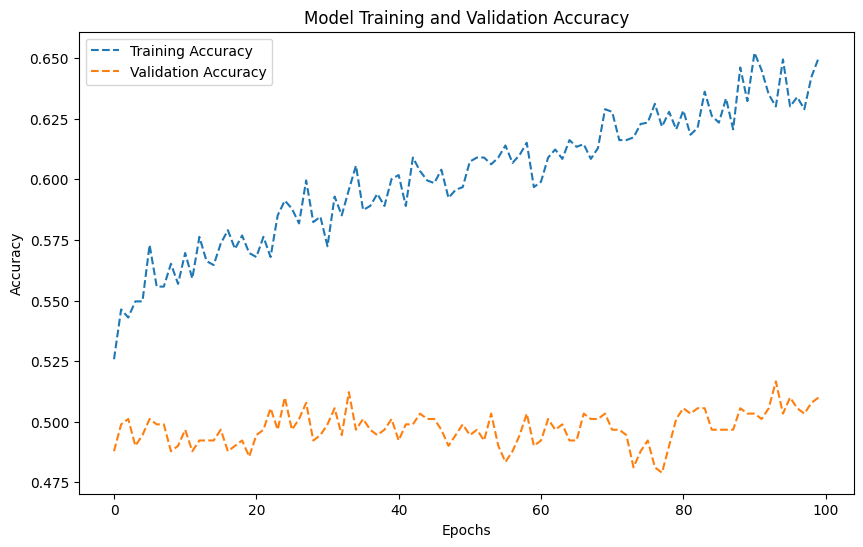

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


C:\Users\aminj\AppData\Local\Temp\ipykernel_52352\2079052308.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['prediction'] = np.where(train_predictions > 0.55, 1, -1)  # Adjusted threshold to reduce noise
C:\Users\aminj\AppData\Local\Temp\ipykernel_52352\2079052308.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['strategy'] = train_set['prediction'] * train_set['return']


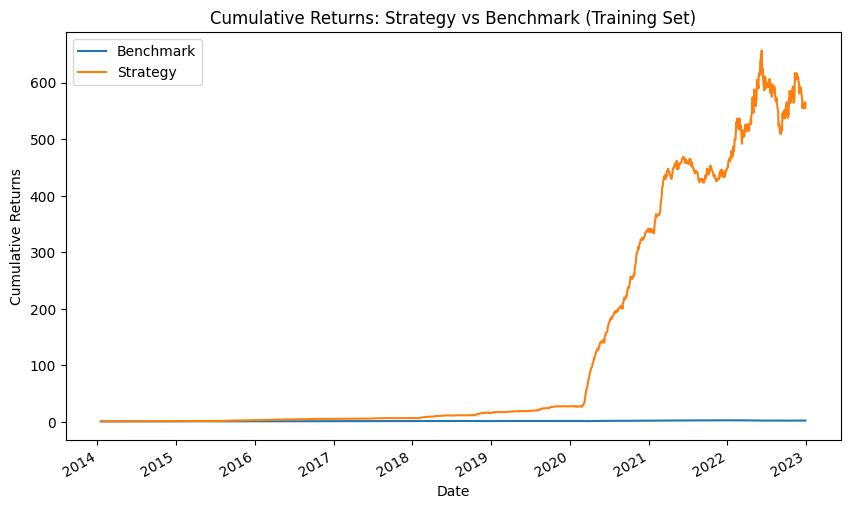

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\aminj\AppData\Local\Temp\ipykernel_52352\2079052308.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['prediction'] = np.where(test_predictions > 0.55, 1, -1)  # Same threshold as training
C:\Users\aminj\AppData\Local\Temp\ipykernel_52352\2079052308.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['strategy'] = test_set['prediction'] * test_set['return']


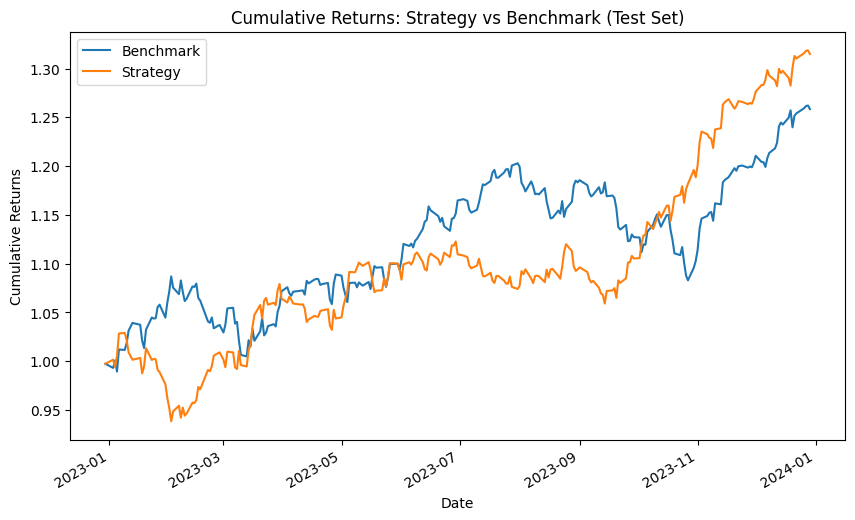

Training Performance:
Ticker
return        2.453852
strategy    564.523885
dtype: float64
Test Performance:
Ticker
return      1.258434
strategy    1.314848
dtype: float64


In [6]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
import tensorflow as tf
import random

# Set Random Seed for Reproducibility
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Download SPY Data
symbol = 'SPY'
data = yf.download(symbol, start="2014-01-01", end="2023-12-31")["Adj Close"]

# Prepare DataFrame
data = pd.DataFrame(data)
data.rename(columns={data.columns[0]: 'Adj Close'}, inplace=True)

# Calculate Log Returns
data['return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Define Market Direction (1 for upward, 0 for downward)
data['direction'] = np.where(data['return'] > 0, 1, 0)

# Create Lagged Features
lags = 10  # Increased lags for better signal exploration
for lag in range(1, lags + 1):
    data[f'lag_{lag}'] = data['return'].shift(lag)

# Drop Missing Values
data.dropna(inplace=True)

# Train-Test Split
train_size = int(0.9 * len(data))  # Adjust split for more recent test evaluation
train_set, test_set = data.iloc[:train_size], data.iloc[train_size:]

# Normalize Data
mu, std = train_set.mean(), train_set.std()
train_set_normalized = (train_set - mu) / std
test_set_normalized = (test_set - mu) / std

# Define Neural Network Model
optimizer = Adam(learning_rate=0.0005)  # Increased learning rate for faster convergence
model = Sequential([
    Input(shape=(lags,)),
    Dense(128, activation='relu'),  # Increased neurons for higher model capacity
    Dropout(0.3),  # Added dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(
    train_set_normalized[[f'lag_{i}' for i in range(1, lags + 1)]],
    train_set['direction'],
    epochs=100,  # Increased epochs for better model fit
    verbose=1,
    validation_split=0.2,
    shuffle=False
)

# Plot Training and Validation Accuracy
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 6))
plt.plot(history_df['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate Model on Training Set
train_predictions = model.predict(train_set_normalized[[f'lag_{i}' for i in range(1, lags + 1)]])
train_set['prediction'] = np.where(train_predictions > 0.55, 1, -1)  # Adjusted threshold to reduce noise
train_set['strategy'] = train_set['prediction'] * train_set['return']

# Plot Training Set Performance
train_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Cumulative Returns: Strategy vs Benchmark (Training Set)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Benchmark', 'Strategy'])
plt.show()

# Evaluate Model on Test Set
test_predictions = model.predict(test_set_normalized[[f'lag_{i}' for i in range(1, lags + 1)]])
test_set['prediction'] = np.where(test_predictions > 0.55, 1, -1)  # Same threshold as training
test_set['strategy'] = test_set['prediction'] * test_set['return']

# Plot Test Set Performance
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Cumulative Returns: Strategy vs Benchmark (Test Set)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Benchmark', 'Strategy'])
plt.show()

# Final Performance Metrics
train_performance = train_set[['return', 'strategy']].sum().apply(np.exp)
test_performance = test_set[['return', 'strategy']].sum().apply(np.exp)
print(f"Training Performance:\n{train_performance}")
print(f"Test Performance:\n{test_performance}")
